# Web Services

In [1]:
from pygeoogc import ArcGISRESTful, WFS, WMS, ServiceURL
import pygeoogc as ogc
import pygeoutils as geoutils
from pynhd import NLDI
import xarray as xr
import numpy as np
import pandas as pd

[PyGeoOGC](https://github.com/cheginit/pygeoogc) and [PyGeoUtils](https://github.com/cheginit/pygeoutils) can be used to access any web services that are based on ArcGIS RESTful, WMS, or WFS. It is noted that although, all these web service have limits on the number of objects (e.g., 1000 objectIDs for RESTful) or pixels (e.g., 8 million pixels) per requests, PyGeoOGC takes care of dividing the requests into smaller chunks under-the-hood and then merges them.

Let's get a watershed geometry using NLDI and use it for subsetting the data.

In [2]:
basin = NLDI().getfeature_byid(
    "nwissite",
    "USGS-11092450",
    basin=True
)
basin_geom = basin.geometry[0]

PyGeoOGC, has a function for asynchronous download which can help speed up sending/receiveing requests. For example, let's use this function to get [NDVI](https://daac.ornl.gov/VEGETATION/guides/US_MODIS_NDVI.html) data from DACC server. The function can be directly passed to `xarray.open_mfdataset` to get the data as an xarray Dataset.

In [7]:
west, south, east, north = basin_geom.bounds
base_url = "https://thredds.daac.ornl.gov/thredds/ncss/ornldaac/1299"
urls = []
years = np.arange(2000, 2005)
dates_itr = [(pd.to_datetime(f"{y}-01-01"), pd.to_datetime(f"{y}-01-31")) for y in years]

for s, e in dates_itr:
    urls.append(
        base_url
        + "&".join(
            [
                f"MCD13.A{s.year}.unaccum.nc4?",
                f"var=NDVI",
                f"north={north}",
                f"west={west}",
                f"east={east}",
                f"south={south}",
                "disableProjSubset=on",
                "horizStride=1",
                f'time_start={s.strftime("%Y-%m-%dT%H:%M:%SZ")}',
                f'time_end={e.strftime("%Y-%m-%dT%H:%M:%SZ")}',
                "timeStride=1",
                "addLatLon=true",
                "accept=netcdf",
            ]
        )
    )
data = xr.open_mfdataset(ogc.async_requests(urls, "binary", max_workers=8))

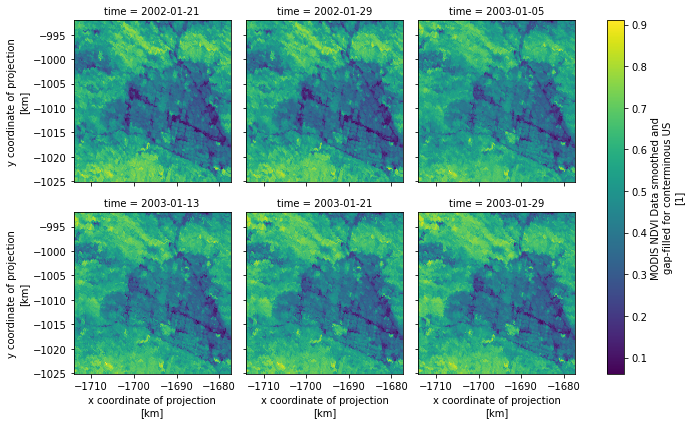

In [12]:
data.isel(time=slice(10, 16)).NDVI.plot(x="x", y="y", row="time", col_wrap=3);

Moreover, PyGeoOGC has a ``NamedTuple`` called ``ServiceURL`` that contains URLs of the some of the popular web services. Let's use it to access NHDPlus HR Dataset RESTful service and get all the catchments that our basin contain and use ``pygeoutils.json2geodf`` to convert it into a GeoDataFrame.

In [3]:
hr = ArcGISRESTful(ServiceURL().restful.nhdplushr, outformat="json")
hr.layer = 10
hr.spatial_relation = "esriSpatialRelContains"
hr.oids_bygeom(basin_geom, "epsg:4326")
resp = hr.get_features()
catchments = geoutils.json2geodf(resp)

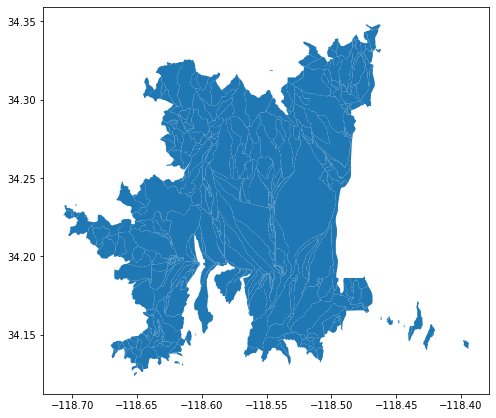

In [4]:
catchments.plot(figsize=(8, 8));

Note ``oids_bygeom`` has an additional argument for passing any valid SQL WHERE clause to further filter the data on the server side. For example, let's only keep the ones with an area of larger than 0.5 sqkm.

In [5]:
hr.oids_bygeom(basin_geom, geo_crs="epsg:4326", sql_clause="AREASQKM > 0.5")
resp = hr.get_features()
catchments = geoutils.json2geodf(resp)

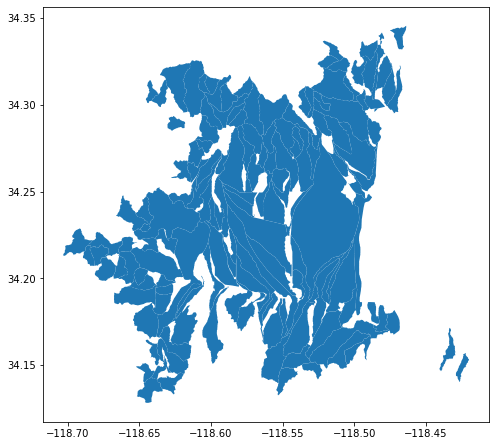

In [6]:
catchments.plot(figsize=(8, 8));

We can also submit a query based on IDs of any valid field in the database. If the measure
property is desired you can pass ``return_m`` as ``True`` to the ``get_features`` class method:

In [7]:
hr.oids_byfield("NHDPLUSID", [5000500013223, 5000400039708, 5000500004825])
resp = hr.get_features(return_m=True)
catchments = geoutils.json2geodf(resp)

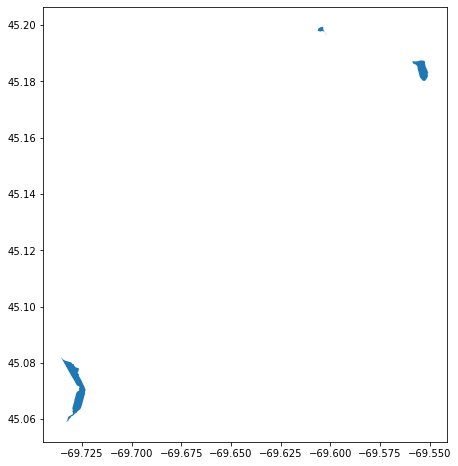

In [8]:
catchments.plot(figsize=(8, 8));

Next, let's get wetlands using the [National Wetlands Inventory](https://www.fws.gov/wetlands/) WMS service. First we need to connect to the service using ``WMS`` class.

In [9]:
wms = WMS(
    ServiceURL().wms.fws,
    layers="0",
    outformat="image/tiff",
    crs="epsg:3857",
)

In [10]:
wms

Connected to the WMS service with the following properties:
URL: https://www.fws.gov/wetlands/arcgis/services/Wetlands_Raster/ImageServer/WMSServer
Version: 1.3.0
Layers: 0
Output Format: image/tiff
Output CRS: epsg:3857

Then we can get the data using the ``getmap_bybox`` function. Note that this function only accpets a bounding box, so we need to pass a bounding box and mask the returned data later on usin ``pygeoutils.gtiff2xarray`` function.

In [13]:
r_dict = wms.getmap_bybox(
    basin_geom.bounds,
    1e3,
    box_crs="epsg:4326",
)
wetlands = geoutils.gtiff2xarray(r_dict, basin_geom, "epsg:4326")

There are three bands in the returned data. Using the information provided for the layer [here](https://www.fws.gov/wetlands/arcgis/rest/services/Wetlands/MapServer/0) we can find the color code of emergent wetlands and extract them.

In [14]:
emergent = np.array([127, 195, 28])
wl_emergent = wetlands.where((wetlands.isel(band=0) == emergent[0])
                        & (wetlands.isel(band=1) == emergent[1])
                        & (wetlands.isel(band=2) == emergent[2]))

For plotting the wetlands note that in our request we set the CRS to EPSG:3857 so we need transform the watershed geometry to this CRS so they can be superimposed.

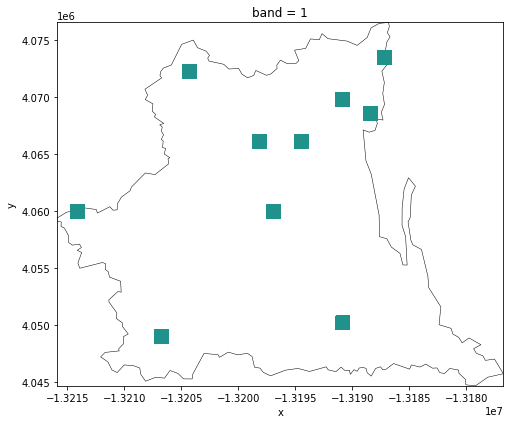

In [17]:
basin_3857 = basin.to_crs("epsg:3857")
ax = basin_3857.plot(facecolor="none", edgecolor="k", lw=0.5, figsize=(8, 8))
wl_emergent.isel(band=0).plot(ax=ax, add_colorbar=False);

Next, let's getthe base flood elevation data from [FEMA](https://hazards.fema.gov/gis/nfhl/rest/services/public/NFHL/MapServer/16) and use ``pygeoutils.json2geodf`` to convert it into a GeoDataFrame.

In [19]:
wfs = WFS(
    ServiceURL().wfs.fema,
    layer="public_NFHL:Base_Flood_Elevations",
    outformat="esrigeojson",
    crs="epsg:4269",
)

In [20]:
wfs

Connected to the WFS service with the following properties:
URL: https://hazards.fema.gov/gis/nfhl/services/public/NFHL/MapServer/WFSServer
Version: 2.0.0
Layer: public_NFHL:Base_Flood_Elevations
Output Format: esrigeojson
Output CRS: epsg:4269

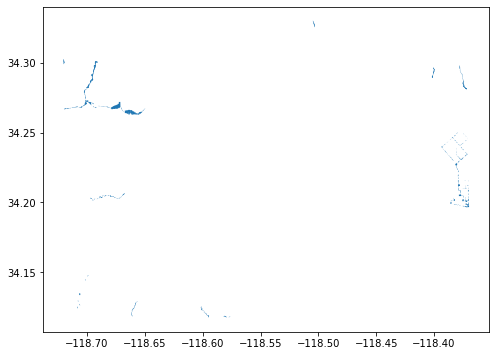

In [21]:
r = wfs.getfeature_bybox(basin_geom.bounds, box_crs="epsg:4326")
flood = geoutils.json2geodf(r.json(), "epsg:4269", "epsg:4326")
flood.plot(figsize=(8, 8));

`WFS` also supports any valid CQL filter.

In [22]:
layer = "wmadata:huc08"
wfs = WFS(
    ServiceURL().wfs.waterdata,
    layer=layer,
    outformat="application/json",
    version="2.0.0",
    crs="epsg:4269",
)
r = wfs.getfeature_byfilter(f"huc8 LIKE '13030%'")
huc8 = geoutils.json2geodf(r.json(), "epsg:4269", "epsg:4326")

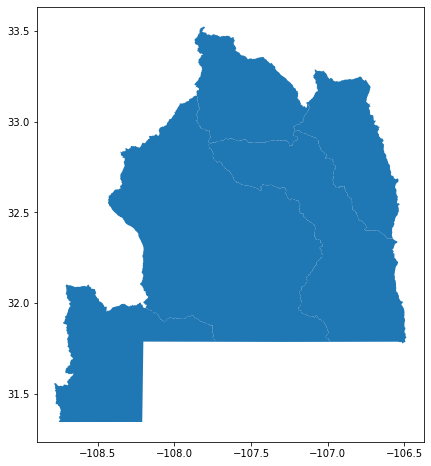

In [23]:
huc8.plot(figsize=(8, 8));